# Generate data using Kramers model

The script will first draw a distribution of molecules and equilibrate. Then for each scenario, simulate, and save in individual files.

For Kramers chain, we need to do an additional normalizing step of flow scenarios, because the model itself is normalized by the segmental diffusion (not the longest relaxation time). Renormalization is given by (Doyle et al. 1997):

$$
Wi = 0.0142 N^2 Pe
$$

In addition, we are primarily interested in mechano-chemistry application, where typical Weissenberg numbers are $\mathcal{O}(100)$. Therefore we choose to have $Wi_\max = 100$ in simulated flows.


In [1]:
import numpy as np
from dilutebrowniandynamics.simulate import simulate_batch
from dilutebrowniandynamics.molecules.adaptive_Kramers_chain import AdaptiveKramersChain

from scipy.interpolate import interp1d

from ipywidgets import interactive, fixed
import ipywidgets as widgets

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 8]

import json

## Parameters definition

In [2]:
Wi_max = 100       # Peak Weissenberg number in simulations
n_links = 1024       # Number of segments in the Kramers chain. To match L_max = {8, 16, 32} we need {64, 256, 1024}
n_ensemble = 256   # Number of molecules to simulate
n_proc = 16        # Number of processor cores to use
                    
# Name: file
scenarios = {
    'turbulence_0': 'inputs/turbulence/scenario_turbulence_0.npz',
#    'turbulence_1': 'inputs/turbulence/scenario_turbulence_1.npz',
#    'turbulence_2': 'inputs/turbulence/scenario_turbulence_2.npz',
#    'turbulence_3': 'inputs/turbulence/scenario_turbulence_3.npz',
#    'turbulence_4': 'inputs/turbulence/scenario_turbulence_4.npz',
#    'inkjet_0': 'inputs/inkjet/scenario_inkjet_0.npz',
#    'contraction_0': 'inputs/contraction/scenario_contraction_0.npz',
#    'contraction_1': 'inputs/contraction/scenario_contraction_1.npz',
#    'contraction_2': 'inputs/contraction/scenario_contraction_2.npz',
#    'contraction_3': 'inputs/contraction/scenario_contraction_3.npz',
#    'contraction_4': 'inputs/contraction/scenario_contraction_4.npz',
#    'contraction_5': 'inputs/contraction/scenario_contraction_5.npz',
#    'contraction_6': 'inputs/contraction/scenario_contraction_6.npz',
#    'elongation_0': 'inputs/elongation/scenario_elongation_0.npz',
#    'elongation_1': 'inputs/elongation/scenario_elongation_1.npz',
#    'elongation_2': 'inputs/elongation/scenario_elongation_2.npz',
#    'random_0': 'inputs/random/scenario_random_0.npz',
#    'random_1': 'inputs/random/scenario_random_1.npz',
#    'random_2': 'inputs/random/scenario_random_2.npz',
#    'random_3': 'inputs/random/scenario_random_3.npz',
#    'random_4': 'inputs/random/scenario_random_4.npz'
}

## Initialise molecules
We call the `from_normal_distribution` constructor. Note that we pass a random seed (`SeedSequence` object) to ensure thread-safe random number generation and reproducible results.

In [3]:
seq = np.random.SeedSequence(2022)
seeds = seq.spawn(n_ensemble)
# Starting vectors
molecules = [AdaptiveKramersChain.from_normal_distribution(n_links, seed)
             for seed in seeds]

## Initial relaxation
Molecular dynamics simulations are usually preceeded by a relaxation/thermalisation step, which in our case is just a simulation with no velocity gradient.

In [4]:
gradU = np.zeros((3, 3))
dt = .01                                    # Time step value (dimensionless)
n_steps = int(0.01*0.0142*n_links**2/dt)       # Equilibriate over 2 relaxation times.
print(f"Number of time steps: {n_steps}")
write_interval = 100   # Record frequency (in number of time steps)
observables, molecules_init = simulate_batch(molecules, gradU, dt, n_steps, 
                                             write_interval=write_interval, 
                                             no_average=['g_max', 'i_max', 'g_centre'], n_proc=n_proc)

Number of time steps: 14889
Physical time to compute: 148.89000000000001
Calculation started on 16 cores.


100%|██████████| 256/256 [34:23<00:00,  8.06s/it] 


We can investigate the dumbbell distribution in a number of ways. Let's look at time series and histograms.

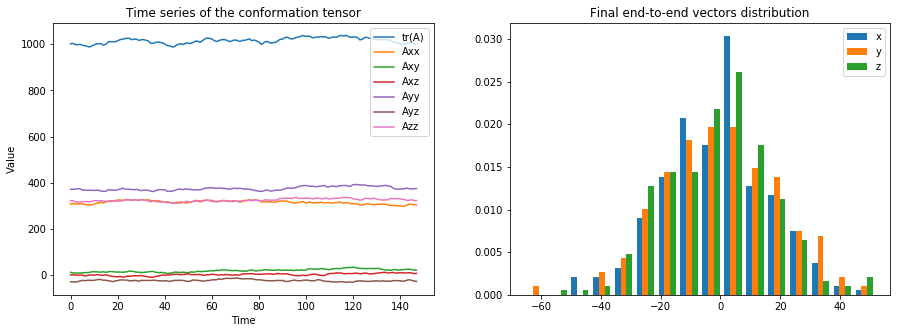

In [5]:
t = np.arange(n_steps//write_interval)*dt*write_interval
A = observables['A_average']
trA = np.trace(A, axis1=1, axis2=2)
REEs = np.array([molecule.REE for molecule in molecules_init])

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 5]
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].plot(t, trA, label='tr(A)')
ax[0].plot(t, A[:,0,0], label='Axx')
ax[0].plot(t, A[:,0,1], label='Axy')
ax[0].plot(t, A[:,0,2], label='Axz')
ax[0].plot(t, A[:,1,1], label='Ayy')
ax[0].plot(t, A[:,1,2], label='Ayz')
ax[0].plot(t, A[:,2,2], label='Azz')
ax[0].legend()
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Value')
ax[0].set_title('Time series of the conformation tensor')
bins = int(np.sqrt(n_ensemble))
ax[1].hist([REEs[:,0], REEs[:,1], REEs[:,2]], bins=bins, density=True, label=['x','y','z'])
ax[1].legend()
ax[1].set_title('Final end-to-end vectors distribution')
plt.show()

## Simulations

Now let's simulate each scenario. We will use the interpolator `scipy.interpolate.interp1d` with the property `kind=previous` for the sudden elongation and random tensor, `kind=linear` for realistic flows.

In [6]:
dt = 0.01
write_interval = 100

simulation_results = []

for name, file in scenarios.items():
    
    # Rescale factor
    # --------------
    f = Wi_max/(0.0142*n_links**2)

    # Build scenario
    # --------------
    scenario = np.load(file)
    t_base = scenario['t']
    t_base = t_base/f
    gradU_base = scenario['gradU']*f
    if name.startswith('elongation') or name.startswith('random'):
        kind='previous'
    else:
        kind='linear'
    gradU = interp1d(t_base, gradU_base, axis=0, kind=kind, bounds_error=False, 
                     fill_value=(gradU_base[0], gradU_base[-1]), assume_sorted=True)
    
    # Simulate
    # --------
    print(f"Simulate {name}")
    print(f"---------{'-'*len(name)}")
    
    n_steps = int(t_base[-1]/dt)
    print(f"Number of time steps: {n_steps}")
    observables, _ = simulate_batch(molecules_init, gradU, dt, n_steps, write_interval=write_interval,
                                    no_average=['g_max', 'i_max', 'g_centre'], n_proc=n_proc)
    observables['t'] = np.arange(n_steps//write_interval)*dt*write_interval
    observables['gradU'] = gradU(observables['t'])
    simulation_results.append(observables)

Simulate turbulence_0
---------------------
Number of time steps: 1327382
Physical time to compute: 13273.82
Calculation started on 16 cores.


  0%|          | 0/256 [1:33:52<?, ?it/s]Process ForkPoolWorker-26:
Process ForkPoolWorker-25:
Process ForkPoolWorker-20:
Process ForkPoolWorker-23:
Process ForkPoolWorker-28:
Process ForkPoolWorker-24:
Process ForkPoolWorker-31:
Process ForkPoolWorker-22:
Process ForkPoolWorker-29:
Process ForkPoolWorker-30:
Process ForkPoolWorker-17:
Process ForkPoolWorker-19:
Process ForkPoolWorker-27:
Process ForkPoolWorker-21:
Process ForkPoolWorker-32:
Process ForkPoolWorker-18:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/etienne/miniconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/etienne/miniconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstr

  File "/home/etienne/Python/DiluteBrownianDynamics/dilutebrowniandynamics/simulate.py", line 131, in simulate
    molecule.solve(gradUt, dt_local)
  File "/home/etienne/Python/DiluteBrownianDynamics/dilutebrowniandynamics/molecules/adaptive_Kramers_chain.py", line 183, in solve
    new_Q2 = np.sum(new_Q**2, axis=1)
  File "/home/etienne/Python/DiluteBrownianDynamics/dilutebrowniandynamics/molecules/adaptive_Kramers_chain.py", line 187, in solve
    RHS = RHS0 + 0.5/dt*np.sum(dQ**2, axis=1)
  File "/home/etienne/Python/DiluteBrownianDynamics/dilutebrowniandynamics/simulate.py", line 131, in simulate
    molecule.solve(gradUt, dt_local)
  File "/home/etienne/Python/DiluteBrownianDynamics/dilutebrowniandynamics/simulate.py", line 131, in simulate
    molecule.solve(gradUt, dt_local)
  File "/home/etienne/Python/DiluteBrownianDynamics/dilutebrowniandynamics/simulate.py", line 131, in simulate
    molecule.solve(gradUt, dt_local)
  File "/home/etienne/Python/DiluteBrownianDynamics/dilutebr

KeyboardInterrupt: 

## Inspect

In [ ]:
def inspect(scenario, line, show_std, show_N2):
    t = simulation_results[scenario]['t']
    obs = simulation_results[scenario]
    
    plt.rcParams['figure.figsize'] = [15, 15]
    figure, ax = plt.subplots(nrows=4)
    
    ax[0].plot(t, obs['A_average'][:,line,0], c='#0c2c84', linewidth=2, label='ix')
    ax[0].plot(t, obs['A_average'][:,line,1], c='#1d91c0', linewidth=2, label='iy')
    ax[0].plot(t, obs['A_average'][:,line,2], c='#7fcdbb', linewidth=2, label='iz')    
    if show_std:
        ax[0].fill_between(t, obs['A_average'][:,line,0] - obs['A_std'][:,line,0],
                       obs['A_average'][:,line,0] + obs['A_std'][:,line,0],
                       label='sigma ix', alpha=0.1)
        ax[0].fill_between(t, obs['A_average'][:,line,1] - obs['A_std'][:,line,1],
                       obs['A_average'][:,line,1] + obs['A_std'][:,line,1],
                       label='sigma iy', alpha=0.1)
        ax[0].fill_between(t, obs['A_average'][:,line,2] - obs['A_std'][:,line,2],
                       obs['A_average'][:,line,2] + obs['A_std'][:,line,2],
                       label='sigma iz', alpha=0.1)
    ax[0].set_title('Conformation tensor')
    ax[0].legend()
    
    ax[1].semilogy(t, obs['A_average'][:,0,0]+obs['A_average'][:,1,1]+obs['A_average'][:,2,2], c='#0c2c84', linewidth=2, label='Tr')
    if show_N2:
        ax[1].axhline(n_links**2, ls='--', label='$N^2$')
        ax[1].axhline(n_links**1.5, ls=':', label='$N^{1.5}$')
        ax[1].axhline(n_links, label='$N$')
        ax[1].legend()
    ax[1].set_title('Trace conformation tensor')
    
    

    ax[2].plot(t, obs['S_average'][:,line,0], c='#0c2c84', linewidth=2, label='ix')
    ax[2].plot(t, obs['S_average'][:,line,1], c='#1d91c0', linewidth=2, label='iy')
    ax[2].plot(t, obs['S_average'][:,line,2], c='#7fcdbb', linewidth=2, label='iz')
    
    if show_std:
        ax[2].fill_between(t, obs['S_average'][:,line,0] - obs['S_std'][:,line,0],
                       obs['S_average'][:,line,0] + obs['S_std'][:,line,0],
                       label='sigma ix', alpha=0.1)
        ax[2].fill_between(t, obs['S_average'][:,line,1] - obs['S_std'][:,line,1],
                       obs['S_average'][:,line,1] + obs['S_std'][:,line,1],
                       label='sigma iy', alpha=0.1)
        ax[2].fill_between(t, obs['S_average'][:,line,2] - obs['S_std'][:,line,2],
                       obs['S_average'][:,line,2] + obs['S_std'][:,line,2],
                       label='sigma iz', alpha=0.1)
    ax[2].set_title('Stress tensor')
    
    ax[3].plot(t, obs['gradU'][:,line,0], c='#0c2c84', linewidth=2, label='ix')
    ax[3].plot(t, obs['gradU'][:,line,1], c='#1d91c0', linewidth=2, label='iy')
    ax[3].plot(t, obs['gradU'][:,line,2], c='#7fcdbb', linewidth=2, label='iz')
    ax[3].set_title('Grad(U) tensor')
    
    plt.show()


w = interactive(inspect, scenario=widgets.Dropdown(
                        options=list(zip(scenarios.keys(), range(len(scenarios)))),
                        value=0,
                        description='Scenario:',
                        disabled=False
                    ),
                    line=widgets.Dropdown(
                        options=[('xx, xy, xz', 0),('yx, yy, yz', 1),('zx, zy, zz', 2)],
                        value=0,
                        description='Line:',
                        disabled=False
                    ),
                    show_std=widgets.Checkbox(
                        value=False,
                        description='Show standard deviation',
                        disabled=False
                    ),
                    show_N2=widgets.Checkbox(
                        value=False,
                        description='Show coil-stretch transistion',
                        disabled=False
                    )
               )
w

## Save result to files

Here we save the result as *numpy arrays* compressed in a single file, as we expect further analysis with Python. Use other tools to save as text files.

In [ ]:
import datetime

params = {'model' : molecules[0].__class__.__name__,
          'n_links' : n_links,
          'n_ensemble' : n_ensemble,
          'dt' : dt,
          'write_interval' : write_interval,
          'n_proc' : n_proc,
          'time stamp' : datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
          }

for i, name in enumerate(scenarios.keys()):
    observables = simulation_results[i]
    np.savez_compressed(f"outputs/Kramers/Wi{Wi_max}_N{n_links}_{name}_n{n_ensemble}", **observables)
    json.dump(params, open( f"outputs/Kramers/Wi{Wi_max}_N{n_links}_{name}_n{n_ensemble}.json", 'w' ) )

In [ ]:
observables['g_max'].shape

In [ ]:
plt.plot(observables['t'], observables['g_max'][0], 'b', alpha = 0.2)
plt.plot(observables['t'], observables['g_max'][1], 'b', alpha = 0.2)
plt.plot(observables['t'], observables['g_max'][2], 'b', alpha = 0.2)
plt.plot(observables['t'], observables['g_max'][3], 'b', alpha = 0.2)
plt.show()